In [2]:
from aeon.datasets import load_airline
#!pip install -U aeon
#!pip install aeon[all_extras]
import warnings
import pandas as pd
import numpy as np
from aeon.datasets import load_airline
# from aeon.forecasting.arima import ARIMA
from matplotlib import pyplot as plt
from aeon.forecasting.arima import AutoARIMA
from aeon.forecasting.sarimax import SARIMAX
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_percentage_error as mape
from aeon.visualisation import plot_series
from aeon.transformations.detrend import Deseasonalizer
from all_functions import *
warnings.filterwarnings("ignore")
%matplotlib inline
horizon = 12

def mcpm_func(rmse_result, mape_result, pocid_result):
  er_result = 100 - pocid_result

  A1 = (rmse_result * mape_result * np.sin((2*np.pi)/3))/2
  A2 = (mape_result * er_result * np.sin((2*np.pi)/3))/2
  A3 = (er_result * rmse_result * np.sin((2*np.pi)/3))/2
  total = A1 + A2 + A3
  return total

/home/user/miniconda3/envs/lucas/lib/python3.11/site-packages/rapids_dask_dependency/dask_loader.py:36: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  mod = importlib.import_module(spec.name)


In [3]:
import os

# pastas = [ 
#           './Statistics_and_Seq2Seq/results/arima/rolling/gasolinac',
#           './Statistics_and_Seq2Seq/results/arima/rolling/oleodiesel',
#           './Statistics_and_Seq2Seq/results/arima/rolling/etanolhidratado',
#           './Statistics_and_Seq2Seq/results/arima/rolling/gasolinadeaviacao',
#           './Statistics_and_Seq2Seq/results/arima/rolling/glp',
#           './Statistics_and_Seq2Seq/results/arima/rolling/oleocombustivel',RP
#           './Statistics_and_Seq2Seq/results/arima/rolling/querosenedeaviacao',
#           './Statistics_and_Seq2Seq/results/arima/rolling/queroseneiluminante'
#           ]

pastas = [
          '../results/varma/rolling/gasolinac',
        #   './Statistics_and_Seq2Seq/results/sarima/rolling/oleodiesel',
        #   './Statistics_and_Seq2Seq/results/sarima/rolling/etanolhidratado',
        #   './Statistics_and_Seq2Seq/results/sarima/rolling/gasolinadeaviacao',
        #   './Statistics_and_Seq2Seq/results/sarima/rolling/glp',
        #   './Statistics_and_Seq2Seq/results/sarima/rolling/oleocombustivel',
        #   './Statistics_and_Seq2Seq/results/sarima/rolling/querosenedeaviacao',
        #   './Statistics_and_Seq2Seq/results/sarima/rolling/queroseneiluminante'
          ]


dfs_por_transformacao = {}

for pasta in pastas:
    if os.path.isdir(pasta):
        for arquivo in os.listdir(pasta):
            if arquivo.endswith('.csv'):
                caminho_arquivo = os.path.join(pasta, arquivo)
                df = pd.read_csv(caminho_arquivo, delimiter=';')
                
                for transformacao, grupo in df.groupby('DATA'):
                    if transformacao not in dfs_por_transformacao:
                        dfs_por_transformacao[transformacao] = grupo.copy()
                    else:
                        dfs_por_transformacao[transformacao] = pd.concat(
                            [dfs_por_transformacao[transformacao], grupo], ignore_index=True
                        )


In [4]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

path_data = "../datasets/venda/mensal/uf"
# cores_uf = {
#     'AC': 'green', 'AL': 'green', 'AP': 'green', 'AM': 'green', 'BA': 'green',
#     'CE': 'green', 'DF': 'green', 'ES': 'green', 'GO': 'green', 'MA': 'green',
#     'MT': 'green', 'MS': 'green', 'MG': 'green', 'PA': 'green', 'PB': 'green',
#     'PR': 'blue', 'PE': 'green', 'PI': 'green', 'RJ': 'green', 
#     'RN': 'green', 'RS': 'green', 'RO': 'green', 'RR': 'green', 
#     'SC': 'green', 'SP': 'red', 'SE': 'green', 'TO': 'green'
# }

def safe_eval(preds):
    try:
        # Remover quebras de linha e espaços desnecessários
        preds_clean = preds.replace('\n', ' ').replace('  ', ' ')
        # Remover espaços entre números
        preds_clean = ' '.join(preds_clean.split())
        preds_clean = preds_clean.replace(' ', ',')
        return ast.literal_eval(preds_clean)
    except Exception as e:
        print(f"Erro ao converter: {e}")
        return None
cores_uf = {
    'AC': 'red', 'AL': 'green', 'AP': 'blue', 'AM': 'yellow', 'BA': 'orange',
    'CE': 'purple', 'DF': 'brown', 'ES': 'pink', 'GO': 'gray', 'MA': 'olive',
    'MT': 'cyan', 'MS': 'magenta', 'MG': 'lime', 'PA': 'black', 'PB': 'navy',
    'PR': 'teal', 'PE': 'darkorange', 'PI': 'royalblue', 'RJ': 'salmon', 
    'RN': 'lightgreen', 'RS': 'violet', 'RO': 'gold', 'RR': 'sienna', 
    'SC': 'skyblue', 'SP': 'darkred', 'SE': 'dodgerblue', 'TO': 'tomato'
}

data_test = {}
data_preds = {}
def ler_dados(pastas_filtros):
    dfs_por_transformacao = []
    
    for item in pastas_filtros:
        pasta, filtro_data, coluna_filtro, label = item['pasta'], item['filtro'], item['coluna_filtro'], item['label']
        if os.path.isdir(pasta):
            for arquivo in os.listdir(pasta):
                if arquivo.endswith('.csv'):
                    derivado = pasta.split("/")[-1]
                    uf = arquivo.split("_")[1][:2]
                    caminho_arquivo = os.path.join(pasta, arquivo)
                    df = pd.read_csv(caminho_arquivo, sep=';')
                    # series = read_series(path_data+"/"+derivado+f"/mensal_{uf.lower()}_{derivado}.csv")
                    # train, test = train_test_stats(series, horizon)
                    # y_baseline = series[-horizon*2:-horizon].values
                    # data_test[f'{pasta.split("/")[2]+"-"+filtro_data}_{uf}'] = test
                    df_filtrado = df[df[coluna_filtro] == filtro_data]
                    if 'PREDS' in df_filtrado.columns:
                        predictions = df_filtrado['PREDS'].apply(safe_eval)
                        print(predictions)
                    else:
                        predictions = df_filtrado.loc[:, 'P1':'P12']
                        predictions = predictions.values.flatten().tolist()
                    # predictions = pd.Series(predictions, index=test.index)
                    # data_preds[f'{pasta.split("/")[3]+"-"+filtro_data}_{uf}'] = predictions
                    # mase_result = mase(test, predictions, y_baseline)
                    # df_filtrado["MASE"] = mase_result
                    df_filtrado['Filtro'] = label
                    dfs_por_transformacao.append(df_filtrado)
    
    return pd.concat(dfs_por_transformacao, ignore_index=True)

def gerar_boxplot(df, coluna_metrica, title="-", x_label = "Filters", cores_uf=None):
    plt.figure(figsize=(10, 6))
    
    if coluna_metrica == 'POCID':
        quartis = df.groupby('Filtro')[coluna_metrica].quantile(0.75)
        ordenacao_quartil = quartis.sort_values(ascending=False).index
        
        df['Filtro'] = pd.Categorical(df['Filtro'], categories=ordenacao_quartil, ordered=True)
        ordenacao = ordenacao_quartil
    else:
        medianas = df.groupby('Filtro')[coluna_metrica].median()
        proximidade_mediana = (medianas - 0).abs()
        ordenacao_mediana = proximidade_mediana.sort_values().index
        
        df['Filtro'] = pd.Categorical(df['Filtro'], categories=ordenacao_mediana, ordered=True)
        ordenacao = ordenacao_mediana

    # Criando boxplot
    sns.boxplot(x='Filtro', y=coluna_metrica, data=df, palette='pastel', order=df['Filtro'].cat.categories)
    
    # Adicionando pontos sobre o boxplot
    # sns.stripplot(x='Filtro', y=coluna_metrica, data=df, palette='dark', jitter=True, alpha=0.5, dodge=False, order=df['Filtro'].cat.categories)


    plt.title(f"{title}")
    plt.xlabel(x_label)
    plt.ylabel(coluna_metrica)
    plt.xticks(rotation=90)
    plt.tight_layout()

    # Ajustando os limites do eixo y
    if coluna_metrica == 'MAPE':
        plt.ylim(0, 0.6) if abs(max(medianas.values)) > 0.2 else plt.ylim(0, 0.3)
    elif coluna_metrica == 'PBE':
        plt.ylim(-40, 70) if abs(max(medianas.values)) > 20 else plt.ylim(-20, 20)
    elif coluna_metrica == 'POCID':
        plt.ylim(0, 100)
    
    plt.axhline(y=0, color='red', linestyle='-')  

    # Linha horizontal na mediana mais próxima
    mediana_prox = quartis.loc[ordenacao[0]] if coluna_metrica == 'POCID' else medianas.loc[ordenacao[0]]
    plt.axhline(y=mediana_prox, color='red', linestyle='--')  

    # Criando a legenda
    if cores_uf:
        # Ajustar a paleta de cores usando as cores de cores_uf, repetindo se necessário
        palette = [cores_uf[i % len(cores_uf)] for i in range(len(ordenacao))]
    else:
        palette = sns.color_palette("pastel", n_colors=len(ordenacao))  # Fallback para uma paleta padrão

    filtro_handles = [plt.Line2D([0], [0], color=palette[i], lw=4, label=filtro) for i, filtro in enumerate(ordenacao)]
    
    plt.legend(handles=filtro_handles, title='Modelos & Transformações', bbox_to_anchor=(1, 1), loc='upper left', fontsize='small')
    
    plt.show()

produto = "gasolinac"
filtro = '2023-03_2024-02'
resultado_pasta = 'results'
pastas_filtros = [

 ]
# coluna_metrica = "MAPE"  #"MCPM", "PBE", "RMSE", "POCID" ou "MAPE"

# df_consolidado = ler_dados(pastas_filtros)

# gerar_boxplot(df_consolidado, coluna_metrica, title=f"Venda de {produto} {filtro} em todos os estados", x_label="Modelos com transformações")


In [5]:
import os
import pandas as pd

def read_paper_roma(pastas_filtros):
    dfs_por_transformacao = []
    
    for item in pastas_filtros:
        pasta_base, filtros_data, coluna_filtro, label = item['pasta'], item['filtros'], item['coluna_filtro'], item['label']
        subdiretorios = [
                        "normal", 
                        #  "deseasonal", 
                        #  "log"
                         ]

        # if "SWT" in pasta_base:
        #     subdiretorios.append("deseasonal") 
        # Verifica se a pasta base existe
        if os.path.isdir(pasta_base):
            # Percorre os subdiretórios: normal, deseasonal e log
            for subdir in subdiretorios:
                subdir_path = os.path.join(pasta_base, subdir)
                if os.path.isdir(subdir_path):
                    # Percorre todos os arquivos CSV do subdiretório
                    for arquivo in os.listdir(subdir_path):
                        if arquivo.endswith('.csv'):
                            caminho_arquivo = os.path.join(subdir_path, arquivo)
                            derivado = pasta_base.split("/")[-1]
                            uf = arquivo.split("_")[1][:2]
                            df = pd.read_csv(caminho_arquivo, sep=';')
                            path_data = "../datasets/venda/mensal/uf"
                            series = read_series(path_data+"/"+derivado+f"/mensal_{uf.lower()}_{derivado}.csv")
                            
                            # Inicializa a lista para armazenar as previsões concatenadas
                            concat_predictions = []
                            concat_tests = []
                            
                            # Aplica o filtro baseado nos anos e concatena as previsões
                            for filtro_data in filtros_data:
                                df_filtrado = df[df[coluna_filtro] == filtro_data]
                                
                                if not df_filtrado.empty:
                                    if 'PREDS' in df_filtrado.columns:
                                        predictions = df_filtrado['PREDS'].apply(safe_eval)
                                    else:
                                        predictions = df_filtrado.loc[:, 'P1':'P12'].values.flatten().tolist()
                                    
                                    start_date, end_date = filtro_data.split('_')
                                    test_filtro = get_test_real(series, start_date, end_date)

                                    concat_tests.extend(test_filtro)
                                    concat_predictions.extend(predictions)
                            
                            # Se houver previsões concatenadas, cria um novo DataFrame
                            if concat_predictions:
                                
                                rmse_result = rmse(concat_tests, concat_predictions)
                                mape_result = mape(concat_tests, concat_predictions)
                                pocid_result = pocid(concat_tests, concat_predictions)
                                pbe_result = pbe(pd.Series(concat_tests), pd.Series(concat_predictions))
                                mcpm_result = mcpm(rmse_result, mape_result, pocid_result)

                                df_final = pd.DataFrame({
                                    'UF': [uf],
                                    'PRODUCT': [derivado],
                                    'concat_predictions': [concat_predictions],
                                    'concat_tests': [concat_tests],
                                    'Filtro': [label],
                                    'Transformacao': [subdir],
                                    'MAPE': mape_result,
                                    'PBE': pbe_result,
                                    'POCID': pocid_result,
                                    'RMSE': rmse_result,
                                    'MCPM': mcpm_result
                                })
                                
                                # Adiciona o DataFrame à lista de transformações
                                dfs_por_transformacao.append(df_final)
    
    # Retorna o DataFrame final concatenado
    return pd.concat(dfs_por_transformacao, ignore_index=True) if dfs_por_transformacao else pd.DataFrame()

def gerar_boxplot(df, coluna_metrica, title="-", x_label="Filters", cores_uf=None):
    plt.figure(figsize=(10, 6))
    
    # Cria uma nova coluna com a combinação de Filtro e Transformacao
    df['Filtro_Transformacao'] = df['Filtro'] + " + " + df['Transformacao']
    
    if coluna_metrica == 'POCID':
        quartis = df.groupby('Filtro_Transformacao')[coluna_metrica].quantile(0.75)
        ordenacao_quartil = quartis.sort_values(ascending=False).index
        
        df['Filtro_Transformacao'] = pd.Categorical(df['Filtro_Transformacao'], categories=ordenacao_quartil, ordered=True)
        ordenacao = ordenacao_quartil
    else:
        medianas = df.groupby('Filtro_Transformacao')[coluna_metrica].median()
        proximidade_mediana = (medianas - 0).abs()
        ordenacao_mediana = proximidade_mediana.sort_values().index
        
        df['Filtro_Transformacao'] = pd.Categorical(df['Filtro_Transformacao'], categories=ordenacao_mediana, ordered=True)
        ordenacao = ordenacao_mediana

    # Criando o boxplot
    sns.boxplot(x='Filtro_Transformacao', y=coluna_metrica, data=df, palette='pastel', order=df['Filtro_Transformacao'].cat.categories)
    
    # Adicionando pontos sobre o boxplot (pode ser útil para visualizar dados dispersos)
    # sns.stripplot(x='Filtro_Transformacao', y=coluna_metrica, data=df, palette='dark', jitter=True, alpha=0.5, dodge=False, order=df['Filtro_Transformacao'].cat.categories)
    
    plt.title(f"{title}")
    plt.xlabel(x_label)
    plt.ylabel(coluna_metrica)
    plt.xticks(rotation=90)
    plt.tight_layout()

    # Ajustando os limites do eixo y de acordo com a métrica
    if coluna_metrica == 'MAPE':
        if abs(max(medianas.values)) > 0.08 and abs(max(medianas.values)) < 0.075:
            plt.ylim(0, 0.2) 
        elif abs(max(medianas.values)) >= 0.2:
            plt.ylim(0, 0.5) 
        elif abs(max(medianas.values)) < 0.2:
            plt.ylim(0, 0.2)
        else:
            plt.ylim(0, 0.5)
    elif coluna_metrica == 'PBE':
        plt.ylim(-10, 10) if abs(max(medianas.values)) > 5 else plt.ylim(-7, 7)
    elif coluna_metrica == 'POCID':
        plt.ylim(0, 100)
    
    # Linha horizontal na mediana
    plt.axhline(y=0, color='red', linestyle='-')  
    mediana_prox = quartis.loc[ordenacao[0]] if coluna_metrica == 'POCID' else medianas.loc[ordenacao[0]]
    plt.axhline(y=mediana_prox, color='red', linestyle='--')  

    # Criando a legenda
    if cores_uf:
        # Ajusta a paleta de cores usando as cores de cores_uf, repetindo se necessário
        palette = [cores_uf[i % len(cores_uf)] for i in range(len(ordenacao))]
    else:
        palette = sns.color_palette("pastel", n_colors=len(ordenacao))  # Fallback para uma paleta padrão

    filtro_handles = [plt.Line2D([0], [0], color=palette[i], lw=4, label=filtro) for i, filtro in enumerate(ordenacao)]
    
    plt.legend(handles=filtro_handles, title='Modelos & Transformações', bbox_to_anchor=(1, 1), loc='upper left', fontsize='small')
    
    plt.show()


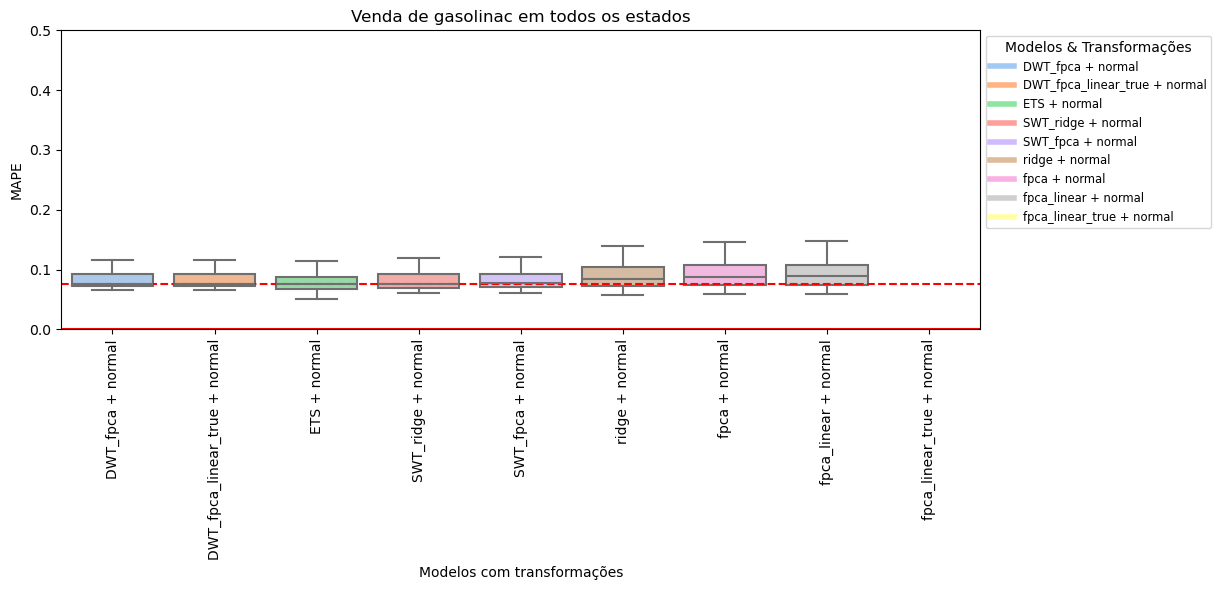

In [18]:
produto = "gasolinac"

ano0 = '2019-03_2020-02'
ano1 = '2020-03_2021-02'
ano2 = '2021-03_2022-02'
ano3 = '2022-03_2023-02'
ano4 = '2023-03_2024-02'

anos_filter = [ano0, ano1, ano2, ano3, ano4]

pastas_filtros = [

  # {'pasta': f'./paper_roma/arima/{produto}', 'filtros': anos_filter, 'coluna_filtro': 'test_range', 'label':'arima'},
  # {'pasta': f'./results/arima_noresid/{produto}', 'filtros': anos_filter, 'coluna_filtro': 'test_range', 'label':'arima_noresid'},
  # {'pasta': f'./results/catboost_noresid/{produto}', 'filtros': anos_filter, 'coluna_filtro': 'test_range', 'label':'catboost_noresid'},
  # {'pasta': f'./paper_roma/catboost/{produto}', 'filtros': anos_filter, 'coluna_filtro': 'test_range', 'label':'catboost'},
  # {'pasta': f'./results/rf_noresid/{produto}', 'filtros': anos_filter, 'coluna_filtro': 'test_range', 'label':'rf_noresid'},
  # {'pasta': f'./results/rf/{produto}', 'filtros': anos_filter, 'coluna_filtro': 'test_range', 'label':'rf'},
  # {'pasta': f'./results/knn/{produto}', 'filtros': anos_filter, 'coluna_filtro': 'test_range', 'label':'knn'},
  # {'pasta': f'./results/knn_noresid/{produto}', 'filtros': anos_filter, 'coluna_filtro': 'test_range', 'label':'knn_noresid'},
  # {'pasta': f'./results/svr_noresid/{produto}', 'filtros': anos_filter, 'coluna_filtro': 'test_range', 'label':'svr_noresid'},
  # {'pasta': f'./results/svr/{produto}', 'filtros': anos_filter, 'coluna_filtro': 'test_range', 'label':'svr'},
  {'pasta': f'./paper_roma/ETS/{produto}', 'filtros': anos_filter, 'coluna_filtro': 'test_range', 'label':'ETS'},
  {'pasta': f'./paper_roma/ridge/{produto}', 'filtros': anos_filter, 'coluna_filtro': 'test_range', 'label':'ridge'},    
  {'pasta': f'./paper_roma/fpca/{produto}', 'filtros': anos_filter, 'coluna_filtro': 'test_range', 'label':'fpca'},    
  {'pasta': f'./paper_roma/fpca_linear/{produto}', 'filtros': anos_filter, 'coluna_filtro': 'test_range', 'label':'fpca_linear'},   
  {'pasta': f'./paper_roma/fpca_linear_true/{produto}', 'filtros': anos_filter, 'coluna_filtro': 'test_range', 'label':'fpca_linear_true'},    
  {'pasta': f'./paper_roma/DWT_fpca_linear_true/{produto}', 'filtros': anos_filter, 'coluna_filtro': 'test_range', 'label':'DWT_fpca_linear_true'},    
  
  {'pasta': f'./paper_roma/SWT_ridge/{produto}', 'filtros': anos_filter, 'coluna_filtro': 'test_range', 'label':'SWT_ridge'},   
  # {'pasta': f'./paper_roma/MTF_ridge/{produto}', 'filtros': anos_filter, 'coluna_filtro': 'test_range', 'label':'MTF_ridge'},    
  # {'pasta': f'./paper_roma/DWT_catboost/{produto}', 'filtros': anos_filter, 'coluna_filtro': 'test_range', 'label':'DWT_catboost'},    
  # {'pasta': f'./paper_roma/RP_ridge/{produto}', 'filtros': anos_filter, 'coluna_filtro': 'test_range', 'label':'RP_ridge'},
  
  #  {'pasta': f'./paper_roma/WPT_ridge/{produto}', 'filtros': anos_filter, 'coluna_filtro': 'test_range', 'label':'WPT_ridge'},
 
 
  {'pasta': f'./paper_roma/DWT_fpca/{produto}', 'filtros': anos_filter, 'coluna_filtro': 'test_range', 'label':'DWT_fpca'},
  {'pasta': f'./paper_roma/SWT_fpca/{produto}', 'filtros': anos_filter, 'coluna_filtro': 'test_range', 'label':'SWT_fpca'},
 

  # {'pasta': f'./paper_roma/SWT_ridge_errado/{produto}', 'filtros': anos_filter, 'coluna_filtro': 'test_range', 'label':'errado_SWT_ridge'},    

  # {'pasta': f'./paper_roma/CWT_ridge/{produto}', 'filtros': anos_filter, 'coluna_filtro': 'test_range', 'label':'CWT_ridge'}, 
  # {'pasta': f'./results/combination3_rf/{produto}', 'filtros': anos_filter, 'coluna_filtro': 'test_range', 'label':'NORESID_COMBINATION'},
  # {'pasta': f'./results/combination_mean/{produto}', 'filtros': anos_filter, 'coluna_filtro': 'test_range', 'label':'mean_combination'},
  # {'pasta': f'./results/combination4_rf/{produto}', 'filtros': anos_filter, 'coluna_filtro': 'test_range', 'label':'SIMPLES_COMBINATION'},  
  # {'pasta': f'./paper_roma/DWT_ridge/{produto}', 'filtros': anos_filter, 'coluna_filtro': 'test_range', 'label':'DWT_ridge'},  
  
]
coluna_metrica = "MAPE"

df_consolidado = read_paper_roma(pastas_filtros)
df_consolidado
gerar_boxplot(df_consolidado, coluna_metrica, title=f"Venda de {produto} em todos os estados", x_label="Modelos com transformações")

In [7]:
estado = "SP"
derivado = "etanolhidratado"
horizon = 12
window = 36
transform = "normal"
model = "rf"
test_date = '2023-03_2024-02'
test_error = get_error_series(f'./results/{model}/{derivado}/{transform}/transform_{estado}.csv', test_date)

preds_error = get_preds_model(f'./error_preds/{model}/{derivado}/meta_rf/{test_date}/transform_{estado}.csv', transform, 'DATA')
# preds_error.reverse()

In [8]:
test_error2 = get_error_series(f'./results/{model}/{derivado}/{transform}/transform_{estado}.csv',  '2022-03_2023-02')
test_error3 = get_error_series(f'./results/{model}/{derivado}/{transform}/transform_{estado}.csv',  '2021-03_2022-02')

conc = test_error3 + test_error2 + test_error

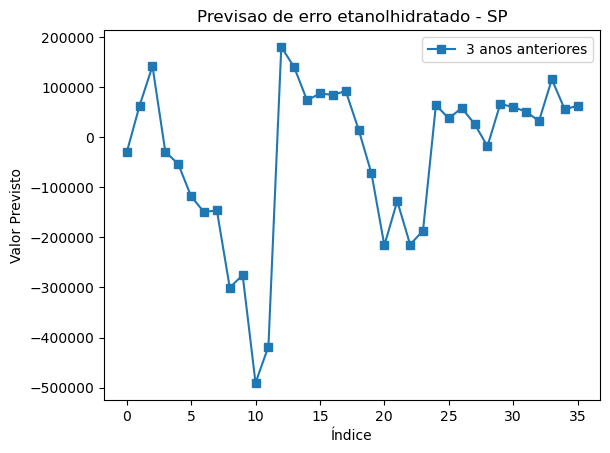

In [9]:
x = range(len(conc))

# plt.plot(x, preds_error, label="Predição do erro", marker='o')
# plt.plot(x, test_error, label="Test do erro", marker='s')
plt.plot(x,conc, label="3 anos anteriores", marker='s')

plt.title(f"Previsao de erro {derivado} - {estado}")
plt.xlabel("Índice")
plt.ylabel("Valor Previsto")

plt.legend()

plt.show()